# Donacilla Cornea: Group Report

**Introduction**

“Donacilla cornea is a small (up to 20mm in length), burrowing intertidal bivalve found on shores of coarse, shelly or pebbly sand, in the Mediterranean and along the Atlantic coast of Europe” (Whiteley et al, 478). Donacillia corneas are soft-bodied marine animals. To explore these Donacilla corneas, we retrieved a dataset from the Institute of Marine Biology NAS Ukraine. We are intrigued by the recovery of Donacilla cornea populations on Ukrainian beaches as they are severely affected by a population bottleneck—a sharp reduction in the size of a population due to environmental events.

The dataset we will be working with includes data manually collected from four locations, each with samples from their “swash zone” (high population density) by using a square sampling frame (10 cm^2) to the depth of 20 cm.

<br>

The four different locations are:

1. Gravel spit of Lake Sasyk-Sivash in the vicinity of Evpatoria city (Crimean peninsula) (153 specimens) 19.05.2013; <br>
2. Southern shore of Dzharylgach Island (Kherson region) with medium-grained sand (40 specimens) 20.08.2016; <br>
3. Beach on Budakskaya Spit (Odessa region) with medium-grained sand (107 specimens) 23–25.08.2017; <br>
4. Shore between villages Grigorovka and Chabanka (Odessa region) with medium-grained sand (35 specimens) 22.08.2019.






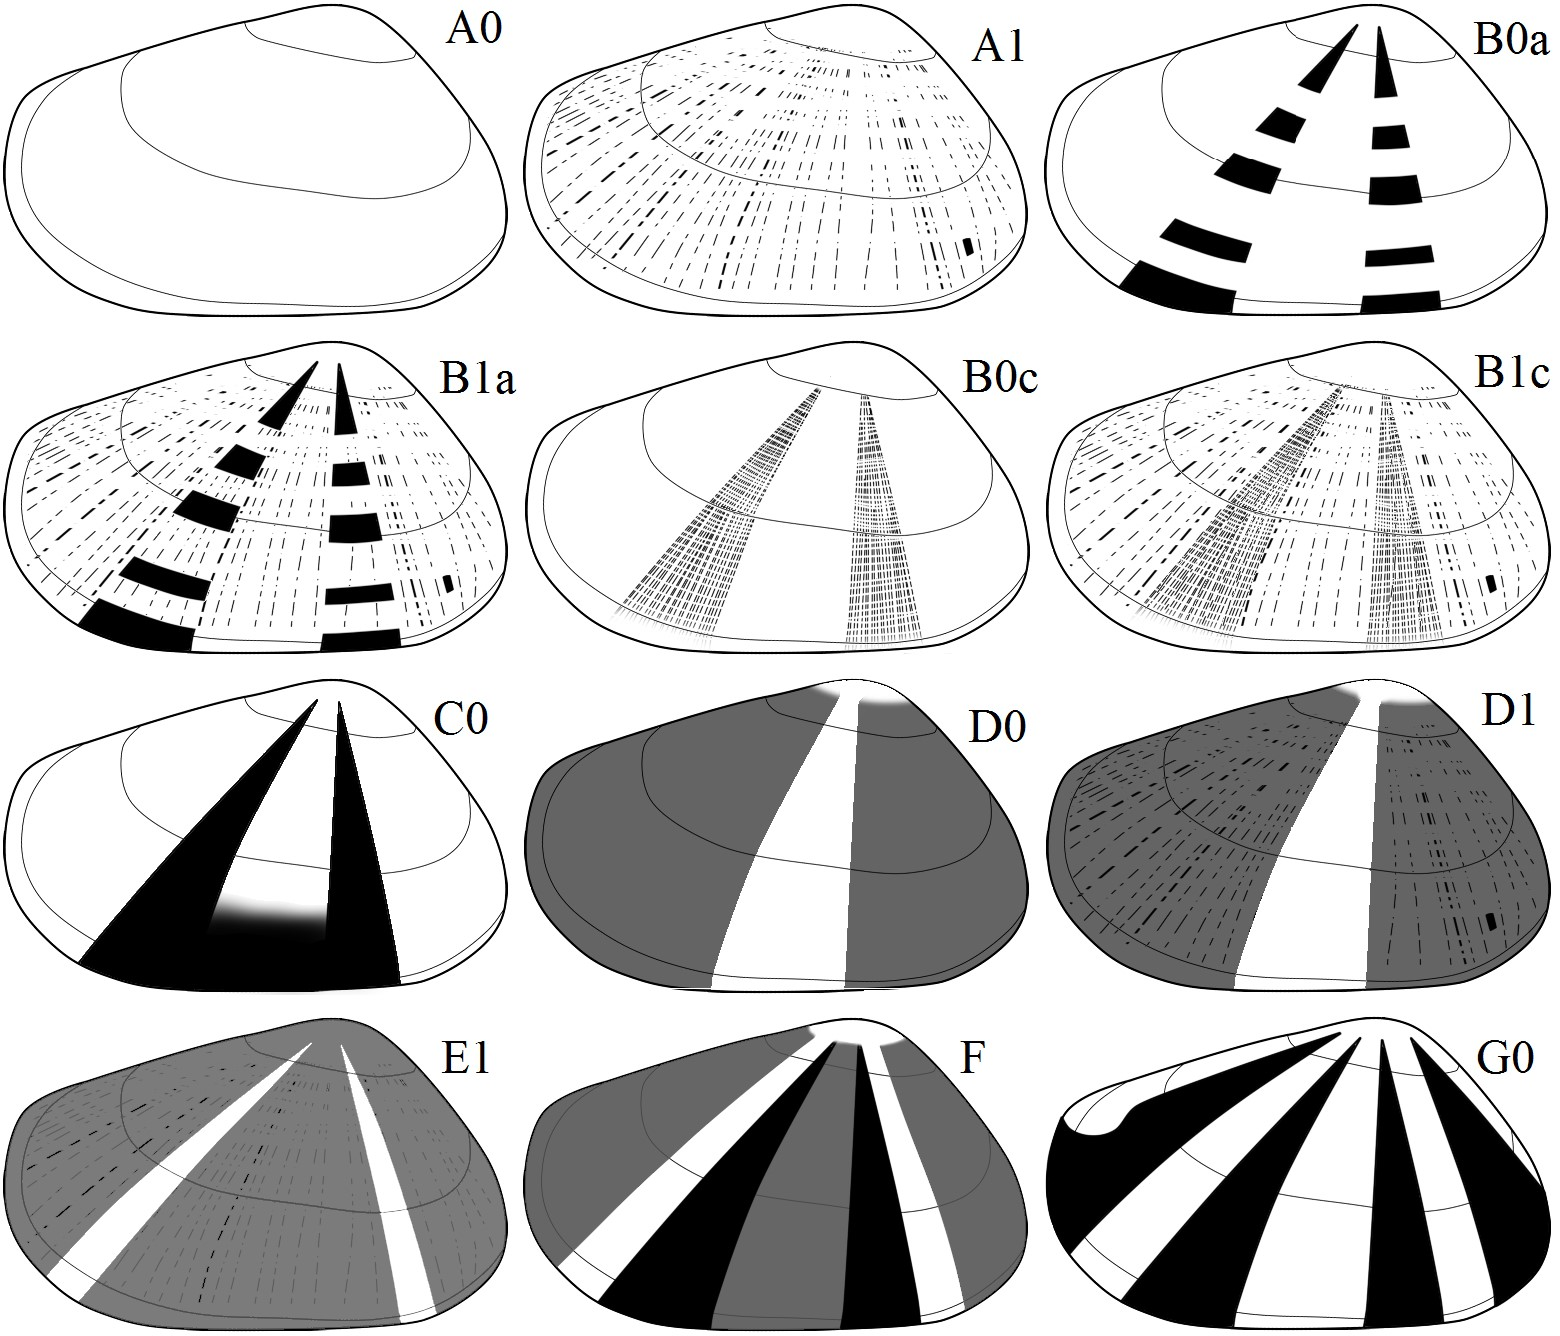






As notated above, total of 12 radial class patterns of Donacilla cornea shells can be found within the dataset. Our goal is to predict these radial class patterns of the affected Donacilla cornea populations, thus our predictive question is:

**How do we predict the radial class pattern of Donacilla cornea using only the length, width, and height?**

**Method**

We start by reading our data into R and tidying our data. We select the three predictor variables (l, w, and h) and one outcome variable chosen for our analysis (rpclass, which encompasses 3 classes A0, A1, and B0A). We then split our data proportionally (0.75 training data, 0.25 testing data) into a testing and testing subset respectively. We do this to ensure we can assess the accuracy of our model which was trained on a training data set. After doing this, we visualize each of the predictor variables by count using a histogram. This allows us to assess the spread, modality, and center of the training data. Next, we create a recipe which includes centering and scaling the variables. To fix the issue of oversampling, we use the ‘step_upsample’ function to make our classes count proportionally equal so that each of the classes has an equal “voting power” in our model. Following this, we execute a 5-fold cross-validation which splits the data into 5 folds, each with training and validation sets. We collect the mean accuracies from the model and graph them against the values for k, choosing the k that results in the highest accuracy. After this, we run a regular classification using the chosen optimal value of k from the 5-fold cross-validation and obtain a set of predictions. We visualize these predictions using the ‘ggpairs’ visualization tool, which allows us to see the relationships between each of the predictor variables, coloured by the rpclass and .pred_class for the training data and the predictions, respectively. This allows us to see the accuracy of our model differently. Finally, we record our analysis and any other required information, providing concluding statements on the accuracy of our classification and reasons for this outcome. 

**Expected Outcomes and Significance**

We hypothesize that a K-value around 3-6 would predict the radial class patterns most accurately—it’s not too large or small. We expect that length, width, and height will be reliable predictors of radial class pattern, ideally yielding a 75% accuracy. 

These findings could be utilized to further understand the qualities of Donacilla cornea shells and how their radial class patterns develop during their life cycle. 

Other possible questions to consider are:
1. Are the length, width, and height predictors effective/relevant?
2. Could we use the ratios as more reliable predictors instead? 
3. Are there other factors we should consider that’s outside of the dataset?

In [13]:
#this cell contains necessary libraries
install.packages("themis")
install.packages("kknn")
install.packages("GGally")
library(kknn)
library(themis)
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Before starting our analysis, we will read the data into R and look at the original data to see what we're working with. 

In [14]:
#read the shell data from the web into r
url <- "https://raw.githubusercontent.com/rhe9598/dsci_group_project/main/Donacilla.csv"
shelldata <- read_csv(url)

#display first few rows of original data
cat("Figure 1: Shell Data\n")
head(shelldata)

Rows: 334 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): population, bg, rpclass, rpcolor, periostracum
dbl (6): l, w, h, w/l, h/l, w/h

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Figure 1: Shell Data


population,l,w,h,w/l,h/l,w/h,bg,rpclass,rpcolor,periostracum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
Budakskaya spit 2017,18.01,5.77,10.80,0.3204,0.5997,0.5343,white,A0,NA,absent
Budakskaya spit 2017,22.11,6.61,12.77,0.2990,0.5776,0.5176,white,A1,transparent,absent
Budakskaya spit 2017,19.36,6.09,12.02,0.3146,0.6209,0.5067,white,A1,grey,absent
Budakskaya spit 2017,19.76,6.46,12.04,0.3269,0.6093,0.5365,gray&purple,A1,black,absent
Budakskaya spit 2017,19.56,5.62,11.63,0.2873,0.5946,0.4832,white,A0,NA,partial
Budakskaya spit 2017,22.88,7.44,14.39,0.3252,0.6289,0.5170,gray,A0,NA,absent


**Step 1:** We have columns in this data set that aren't useful in our data analysis. We will tidy and wrangle our data by removing the classes with low counts and obtaining our predictors

In [15]:
#remove columns that will not be used in our analysis
shellselectdata <- shelldata |>
select(l,w,h,rpclass)

#create a vector for the three classes
classes <- c("A0", "A1" , "B0a")

#filter the data using the values in the vector, transformed rpclass into a factor
shellfilterdata <- shellselectdata |>
                    filter(rpclass %in% classes) |>
                    mutate(rpclass = as_factor(rpclass))

#display first few rows of filtered data only for tidiness
cat("Figure 2: Filtered Shell Data\n")
head(shellfilterdata)

Figure 2: Filtered Shell Data


l,w,h,rpclass
<dbl>,<dbl>,<dbl>,<fct>
18.01,5.77,10.80,A0
22.11,6.61,12.77,A1
19.36,6.09,12.02,A1
19.76,6.46,12.04,A1
19.56,5.62,11.63,A0
22.88,7.44,14.39,A0


The reason we chose length, width, and height as our predictors is because we wanted to see if it was possible to use size of a shell as a way to predict its radial pattern class. We removed the columns besides the rpclass, length, width, and height columns because our goal is to use the individual parameters of length, width, and height as our predictors. Therefore, the other columns are irrelevant to our analysis. 

**Step 2:** We will now split our data proportionally (0.75 and 0.25) to a training and testing subset respectively.

In [16]:
#split the data into testing and training
set.seed(9999)

shell_split <- initial_split(shellfilterdata, prop = 0.75, strata = rpclass)
training_data <- training(shell_split)
testing_data <- testing(shell_split) 

We will then set up data for the primary visualizations for our l, w, and h predictor variables using the training data.

In [17]:
cat("Figure 3: Class Count\n")

#table that shows the counts of each of the classes
class_count <- training_data |>
    group_by(rpclass) |>
    summarize(count = n())
class_count

Figure 3: Class Count


rpclass,count
<fct>,<int>
A0,135
A1,48
B0a,27


In [18]:
cat("Figure 5: Predictor Means\n")

#table that shows the means of each of the predictor variables
predictor_means <- training_data |>
    select(l, w, h) |>
    map_df(mean)

predictor_means

cat("Figure 6: Grouped Predictor Means\n")

#table that shows the means of each predictor variable grouped by rpclass
rpclass_predictor_means <- training_data |>
    group_by(rpclass) |>
    summarize(mean_length = mean(l), mean_width = mean(w), mean_height = mean(h))

rpclass_predictor_means

Figure 5: Predictor Means


l,w,h
<dbl>,<dbl>,<dbl>
17.6979,5.797667,10.84905


Figure 6: Grouped Predictor Means


rpclass,mean_length,mean_width,mean_height
<fct>,<dbl>,<dbl>,<dbl>
A0,17.61859,5.791037,10.84133
A1,17.18208,5.538958,10.45417
B0a,19.01148,6.290741,11.58963


**Step 3:** We will now visualize our training data for each of the predictors (l, w, h).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


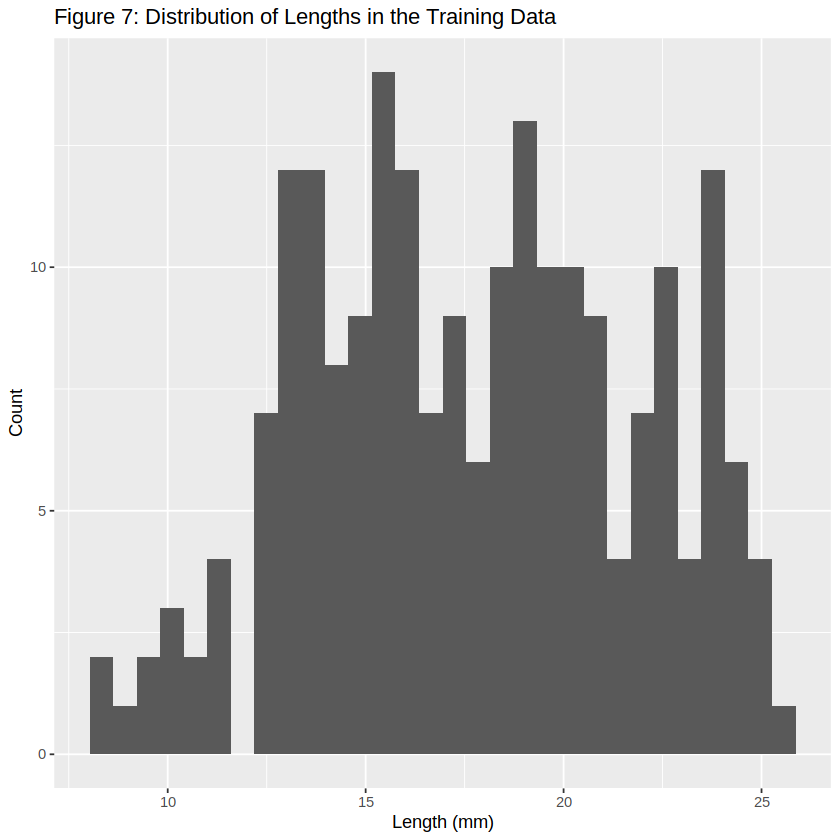

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


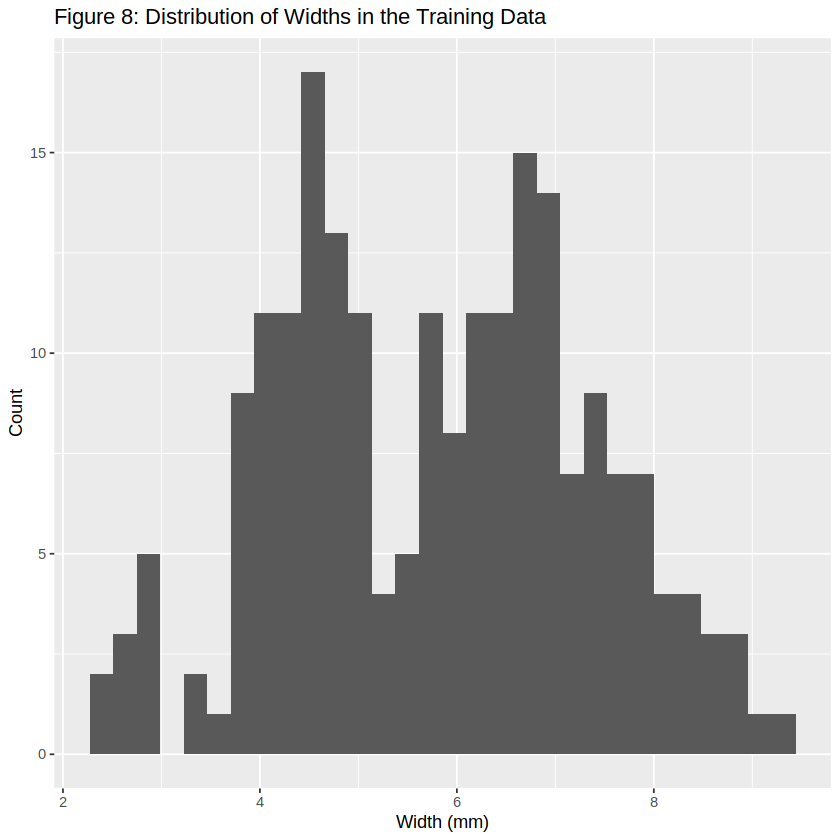

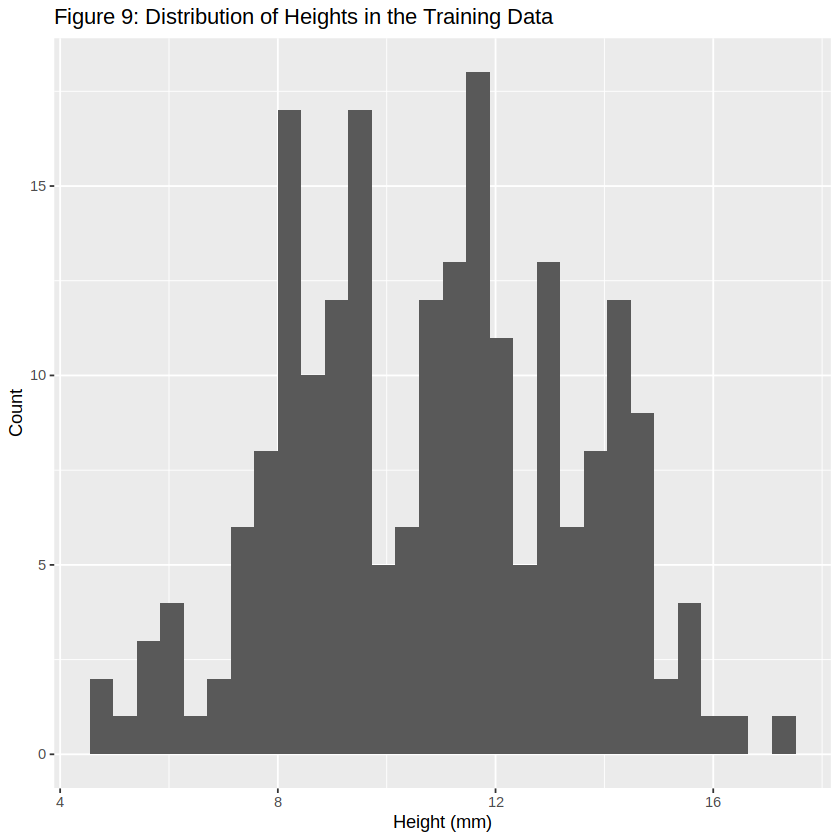

In [19]:
#histogram of the distribution of length
length_distribution <- training_data |>
ggplot(aes(x = l)) +
geom_histogram() +
labs(x = "Length (mm)", y = "Count") +
ggtitle("Figure 7: Distribution of Lengths in the Training Data")

#histogram of the distribution of width
width_distribution <- training_data |>
ggplot(aes(x = w)) +
geom_histogram() +
labs(x = "Width (mm)", y = "Count") +
ggtitle("Figure 8: Distribution of Widths in the Training Data")

#histogram of the distribution of height
height_distribution <- training_data |>
ggplot(aes(x = h)) +
geom_histogram() + 
labs(x = "Height (mm)", y = "Count") +
ggtitle("Figure 9: Distribution of Heights in the Training Data")

length_distribution
width_distribution
height_distribution

All three distributions above are multimodal with multiple peaks and shorter tails. The distributions for length and height have the largest spread, both having ranges of around 18.5 and 14 respectively, and the distribution for width having a range of around 5. 

**Step 4:** We will now create a recipe for our classification model and use the `prep` and `bake` functions to preprocess our data and scale and center all of our predictors.  

In [20]:
set.seed(9999) 

#create model for tuning
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

#create recipe using predictors length, width, and height
shell_recipe <- recipe(rpclass ~ l + w + h, data = training_data) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors())


#fix oversampling issue by using the step_upsample function
upsampled_data <- step_upsample(shell_recipe, rpclass, over_ratio = 1, skip = FALSE) |>
prep()

upsampled_data

shell_upsampled <- bake(upsampled_data, training_data)

cat("Figure 10: Upsampled Grouped Predictor Means\n")

shell_upsampled <- shell_upsampled |>
                group_by(rpclass) |>
                summarize(n = n())

shell_upsampled

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 210 data points and no missing data.

Operations:

Scaling for l, w, h [trained]
Centering for l, w, h [trained]
Up-sampling based on rpclass [trained]

Figure 10: Upsampled Grouped Predictor Means


rpclass,n
<fct>,<int>
A0,135
A1,135
B0a,135


By setting skip = FALSE in the step_upsample function, there are data points that are duplicates in the testing and validation sets. To explain, since tidymodels splits the data into the testing and validation sets for us, it can not process the duplicates because they indicate that information from our training sets has bled into our validation set. If skip was set to TRUE, it would ignore these duplicates. However, by setting it to FALSE we force it run with the duplicates present, resulting in inflated validation accuracies.

**Step 5:** Now, we will split the data into training and validation sets and create a workflow with a tuned k value. This will allow us to assess the accuracy of various values for k, and pick the one with the highest accuracy.  

Figure 11: Testable K-Values


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4850336,5,0.03714110,Preprocessor1_Model01
2,roc_auc,hand_till,0.4832202,5,0.01977171,Preprocessor1_Model01
3,accuracy,multiclass,0.5524134,5,0.02736828,Preprocessor1_Model02
3,roc_auc,hand_till,0.4791358,5,0.01461845,Preprocessor1_Model02
4,accuracy,multiclass,0.5815547,5,0.01687319,Preprocessor1_Model03
4,roc_auc,hand_till,0.4848573,5,0.02002641,Preprocessor1_Model03


Figure 12: Accuracies for Different Sets


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4850336,5,0.03714110,Preprocessor1_Model01
3,accuracy,multiclass,0.5524134,5,0.02736828,Preprocessor1_Model02
4,accuracy,multiclass,0.5815547,5,0.01687319,Preprocessor1_Model03
5,accuracy,multiclass,0.5915377,5,0.03117979,Preprocessor1_Model04
6,accuracy,multiclass,0.6103692,5,0.02838691,Preprocessor1_Model05
7,accuracy,multiclass,0.5913162,5,0.02719420,Preprocessor1_Model06


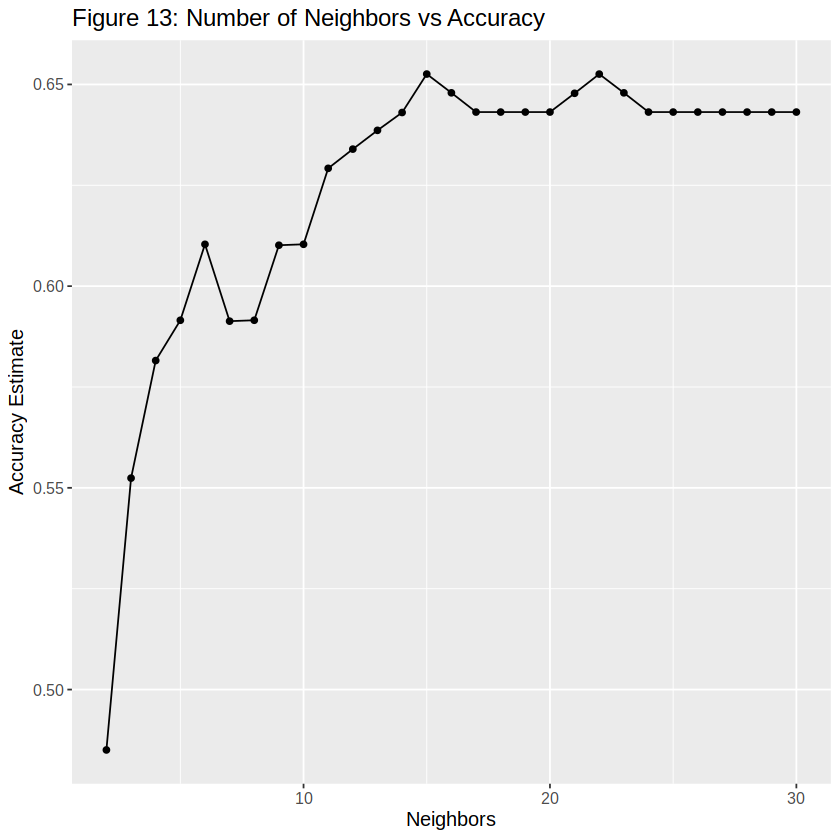

In [21]:
set.seed(9999)
#split data into training and validation sets
vfold <- vfold_cv(training_data, v = 5, strata = rpclass)

cat("Figure 11: Testable K-Values\n")

#create a tibble that contains different values of k to test 
k_vals <- tibble(neighbors = seq(from = 2, to = 30, by = 1))

#create a workflow 
knn_results <- workflow() |>
  add_recipe(shell_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = vfold, grid = k_vals) |>
  collect_metrics() 
head(knn_results)

cat("Figure 12: Accuracies for Different Sets\n")

#filter for accuracy metrics
accuracies <- knn_results |>
  filter(.metric == "accuracy")
head(accuracies)

#create a plot that shows the accuracy corresponding to each k value
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
    ggtitle("Figure 13: Number of Neighbors vs Accuracy")
cross_val_plot


Based on our cross validation plot above, we can see that the highest accuracy occurs when the number of neighbors is 15. We will use k = 15.

**Step 6:** We will now re-create the specification with the optimal k = 15 from the previous step as the number of neighbours. This will allow us to make a new workflow and evaluate the model's accuracy by running the classification on the testing set. 

In [22]:
#create a new model with the best number of neighbors found in the plot/table above
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
      set_engine("kknn") |>
      set_mode("classification")

#create a new workflow with the new model, fitted to the training data to train the model
knn_fit <- workflow() |>
    add_recipe(shell_recipe) |>
    add_model(knn_spec_new) |>
    fit(data = training_data) 
knn_fit

cat("Figure 14: Testable K-Values\n")

#apply the trained model to the testing data
test_predictions <- predict(knn_fit, testing_data) |>
    bind_cols(testing_data)
head(test_predictions)

cat("Figure 15: Accuracies of Test Predictions\n")

#report the model's accuracy
test_prediction_accuracy <- test_predictions |>
    metrics(truth = rpclass, estimate = .pred_class)
test_prediction_accuracy

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(15,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3619048
Best kernel: rectangular
Best k: 15

Figure 14: Testable K-Values


.pred_class,l,w,h,rpclass
<fct>,<dbl>,<dbl>,<dbl>,<fct>
A0,19.36,6.09,12.02,A1
A0,19.83,6.40,12.07,B0a
A0,20.99,7.01,13.68,A0
A0,20.00,5.91,11.68,A1
A0,22.88,7.41,14.38,B0a
A0,20.57,6.96,13.47,A0


Figure 15: Accuracies of Test Predictions


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.61111111
kap,multiclass,-0.01204819


The accuracy of 0.6111 in our model's predictions indicates that the model correctly predicts the class of the data points in our test data set about 61.11% of the time. To further understand this number in the context of our model, we will create a confusion matrix which shows the table of predicted labels and correct labels.

In [23]:
cat("Figure 16: Confusion Matrix\n")

dornea_mat <- test_predictions |>
             conf_mat(truth = rpclass, estimate = .pred_class)

dornea_mat

Figure 16: Confusion Matrix


          Truth
Prediction A0 A1 B0a
       A0  43 15  10
       A1   3  1   0
       B0a  0  0   0

We can see from the confusion matrix above that 43 out of 68 predictions for A0, 1 out of 4 prediction for A1, and 0 out of 0 predictions for B0a were correct. The model was the best at predicting A0 and inadequate at correctly predicting A1 and B0a. It didn't make any predictions for B0A, which suggests that there were issues with model specificity or class imbalance.

**Step 7:** We will now make 2 visualizations that represent our analysis and predictions. The first visualization will show the correlations between each of the predictor variables from the training data, colored by class. The second visualization will show the correlations between each of the predictor variables for each of our predictions, colored by class.

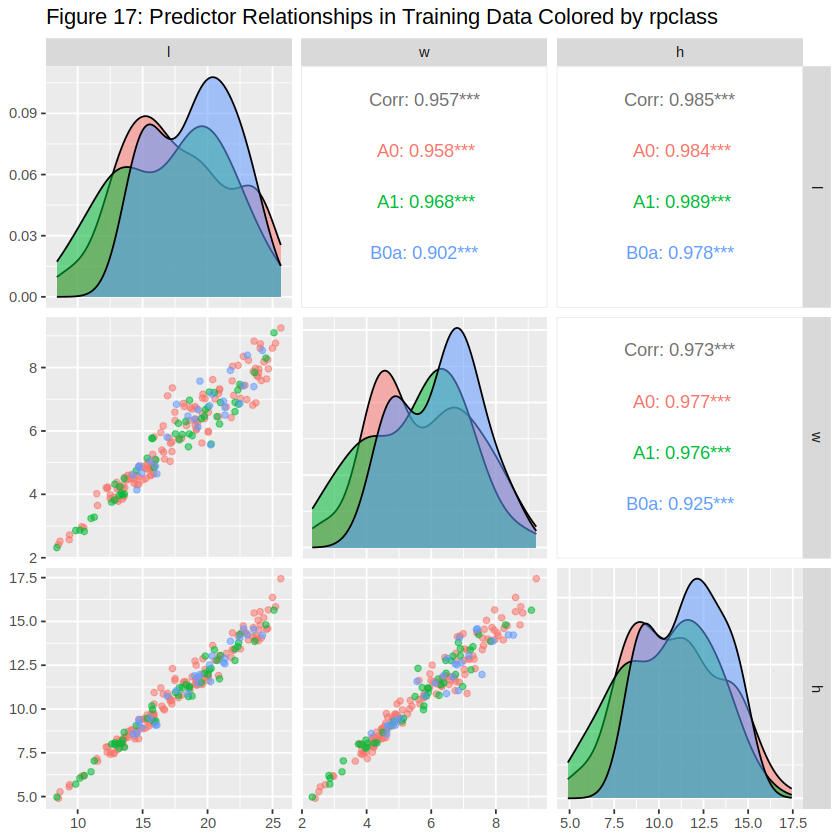

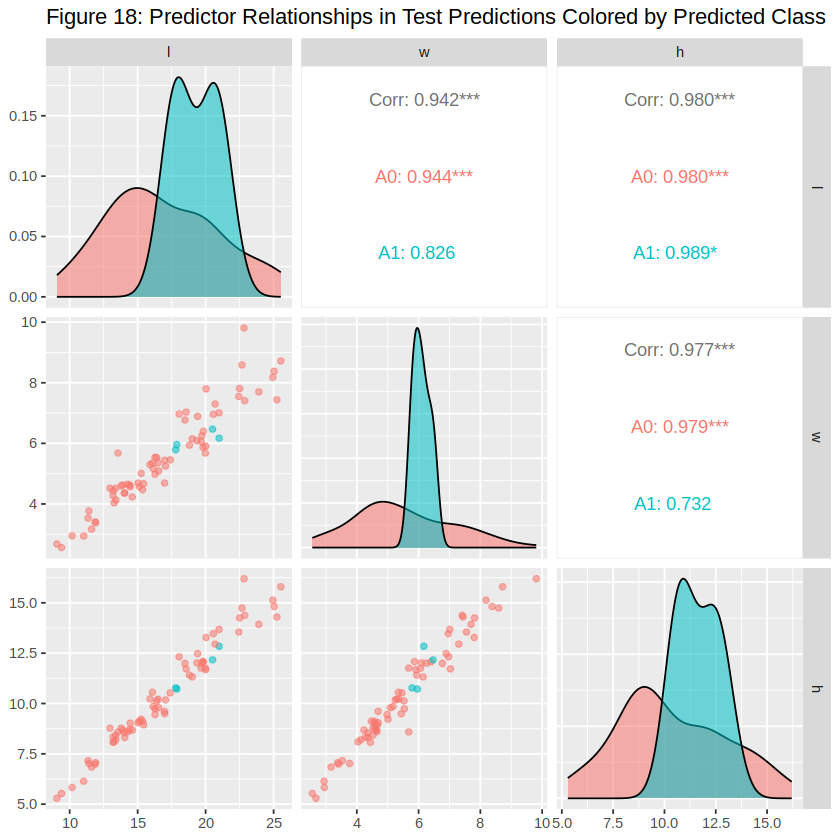

In [24]:
#ggpairs plot of original data, color coded by class
dornea_pairs_original_plot <- training_data |>
                        select(l:h) |>
                        ggpairs(aes(color = training_data$rpclass, alpha = 0.05),
                                title = "Figure 17: Predictor Relationships in Training Data Colored by rpclass")

dornea_pairs_original_plot

#ggpairs plot of new observation, color coded by predicted class
dornea_pairs_predictions_plot <- test_predictions |>
                        select(l:h) |>
                        ggpairs(aes(color = test_predictions$.pred_class, alpha = 0.05),
                                title = "Figure 18: Predictor Relationships in Test Predictions Colored by Predicted Class")

dornea_pairs_predictions_plot

The above visualizations confirm that the majority of the predictions were A0, and there are no predictions for B0a. 

**Step 8**: Conclusion and Final Remarks

Based on the analysis above, we found that our model fit our requirements in some areas, but lacked in others. Some positives and negatives of our model are listed below:

**Positives:**
* Tidy data that is easy to analyse and manipulate, leading to cleaner code and more organized code
* Utilization of 3 predictor variables which lead to a more descriptive analysis 
* Effective visualizations for both the training data and the test predictions that show the effect of various operations and models throughout the project. 
* + Figures 7, 8, and 9 effectively show how the training data is distributed and the general spread, centering, and modality of the data. 
* + Figures 17 and 18 effectively show the relationships between the predictor variables, and their relationships with the true and predicted classes
* Confusion matrix accurately describes the predictions made by the model, making it easier to understand the advantages and drawbacks 

**Negatives:**
* Low accuracy for the given data even though an optimal k-value and proper analysis techniques were used
* Low representation of predictions for A1 and B0a, even though the data were corrected for oversampling/undersampling. 

Looking at these positives and negatives, it is clear that the model accurately identifies and makes predictions. However, there are some challenges faced that may be attributed to multiple factors. These include the possibility that the optimal value of k, particularly for a dataset like ours, could be higher than initially chosen, possibly exceeding 30. Additionally, despite efforts to address issues of a class imbalance using the `step_upsample` function, there might still be an inadequate representation of certain classes, which is a challenge in many real-world datasets. Moreover, the intricacies and complexities of our dataset, including the presence of 3 predictor variables, could contribute to the classification model not fully capturing more accurate predictions.

**Summarize what you found:**
To answer our predictive question: “How do we predict the radial class pattern of the Donacilla cornea using only the length, width, and height?”, we successfully created a KNN algorithm that uses the length, width, and height parameters of the shell to predict its respective radial class. We accompanied this model with a confusion matrix and two visualizations. The first one showcases the relationship between each of the three predictors (length, width, height) within our training data, and the second one displays our model’s predictions based on our predictors. 

By observing the confusion matrix, we found that the classification model made 0 predictions for the radial pattern class B0A, and only 4 predictions for the radial pattern class A1, while making 68 predictions for radial pattern class A0, clearly demonstrating how class A0 dominates the predictions. 

Based on our visualization for our testing predictions, we could see that the majority of correct predictions were classified as A0, while very few shells were classified as A1. The visualization also showed how there were no predictions made at all for the radial pattern class B0A, which was also shown by our confusion matrix. What we found through our visualization was that our classification model can mainly only predict the radial pattern class A0, and very rarely makes predictions for the other two classes. However, it is important to note that while our training data is upsampled, our testing data is not. Our visualization for the test predictions clearly showed how our testing data contained mainly A0, especially when compared to our visualization for the predictor relationships in our training data, which showed a balanced amount of each class. Ultimately, our testing data is extremely unbalanced and the radial pattern class A0 is overrepresented which affects our predictions and this is reflected by our visualization.

**Discuss whether this is what you expected to find:** 
In our initial hypothesis, we expected that length, width, and height would be reliable predictors yielding at least 75% accuracy. In our results, we found an accuracy of 61.11%, which is very inaccurate for a predicting model. This is not close to what we expected to find, and something else we found that was unexpected was that the number of neighbours that yielded the highest cross-validation accuracy was 15, while we had expected to use a K value of around 3-6.

The main reason why our initial hypothesis is fairly inaccurate to our actual results is due to how we did not foresee the inevitable troubles of dealing with a dataset that contains imbalanced observations per class. As radial class A0 had the most observations, the other classes didn’t have any substantial data. Consequently, not only did we have to completely ignore most classes (B1a, B0c, B1c, C0, D0, D1, E1, F, and G0), but we also had to upsample classes A1 and B0a to even match up with the number of observations class A0 had. To note, because our inflated accuracy roots from our inevitable upsampling when skip is set to FALSE, we would also fail to recognize whether the length, width, and height are considered reliable predictors as it is difficult to determine whether these parameters also contributed to our low accuracy or not. Overall, this step in our creation of the KNN model has a detrimental impact on our accuracy.

**Discuss what impact such findings could have:**
Although we successfully programmed a KNN model that can predict the radial class pattern of Donacillia cornea based on its length, width, and height observations, the overall beneficial effects and impacts of the model are unfortunately minimal due to its low accuracy. With a 61.11% accuracy, we can conclude that our model is very flawed in various ways. This can be seen by how it mainly predicts correctly for radial class pattern A0 and not the other two classes, A1 and B0a. Hence, it directly ties back to our upsampling step aforementioned. Since we did not start with sufficient observations for A1 and B0a, the model we created was not able to commute accurate predictions for said classes as there was a lack of unique observations in our original dataset (observations that were not upsampled and duplicated). 

For its applicatory impacts, our low accuracy would suggest how our model could not provide accurate radial classifications of the recovering Donacilla cornea populations on Ukrainian beaches if we were only given the shell’s length, width, and height. Thus, to determine its radial pattern class, we would not recommend letting any new observations taken of these species go through our model. Instead, we would intake these new observations to improve our model through a new dataset where all the radial classes are more equal in the number of observations.

**Discuss what future questions could this lead to:**
From our clear hindrance caused by the upsampled training data, our main question is whether the length, width, and height of Donacilla cornea shells are reliable predictors for radial pattern class after all. If we had access to more available data for radial pattern classes besides A0, A1, and B0a, we could finally determine these parameters’ suitability. Additionally, if we were to discover that the length, width, and height were unreliable predictors, could we use the ratios (w/l, h/l, w/h) as more reliable predictors instead? Other questions we have include, “Are there other factors we should consider that are outside of the dataset?” and “Would it be beneficial to build different classification models for different populations of Donacilla cornea shells, and would this yield higher accuracies?” These questions create a further meaningful investigation on how we could create an improved, more successfully accurate model that can predict the Donacilla cornea radial pattern classes.


# References List

Becker, N. (2016, December 23). The Right Way to Oversample in Predictive Modeling. github.io. December 5, 2023, https://beckernick.github.io/oversampling-modeling/  

(Creative Commons — Attribution-NonCommercial-ShareAlike 4.0 International — CC BY-NC-SA 4.0, n.d.; Whiteley et al., 1997)

Linetskii, B. (2020). Donacilla cornea (poli, 1791) (bivalvia: Venerida: Mesodesmatidae) in the northern black sea: New distribution records, shell size and colouration. *Folia Malacologica, 28(3)*, 210-215. https://doi.org/10.12657/folmal.028.014

Whiteley, D., Owen, D. F., & David. (1997). Massive polymorphism and natural selection in Donacilla cornea (Poli, 1791) (Bivalvia: Mesodesmatidae). *Biological Journal of the Linnean Society, 62(4)*, 475–494. https://doi.org/10.1111/j.1095-8312.1997.tb00316.x